# Challenge 1: P > N

## Daniel Rodriguez-Gonzalez

### Problem Statement:

As consultants, we are often required to make inferences based on limited amounts of data.  In this dataset, with more variables than observations, traditional tools such as logistic regression fail. 

You'll be provided with a dataset with 300 random variables (each drawn from [0,1]). A secret algorithm was used to compute a binary target variable based on these data.

The training dataset has 250 rows, and the test dataset has 19,750 rows. The goal is to build a model based on the training dataset that accurately classifies the test dataset.

Submit your best predicted probabilities for the 19,750 Target_Evaluate variable (which ranges from 0-1).  Be careful what variable selection techniques you use, and don’t overfit -- you'll be evaluated using area under the ROC curve.

# Importing Libraries and Dataset

In [1]:
# Importing libraries for modeling and visualizations
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Import dataset from data.csv into a pandas dataframe
df = pd.read_csv('data.csv')

#Gather some information on the dataset
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 303 entries, id to var_300
dtypes: float64(300), int64(3)
memory usage: 46.2 MB


# Exploratory Data Analysis:

In [3]:
#A brief summary of the dataset's contents, df.head() displays the top 5 rows in the dataframe
print ('The entire dataset contains',df.shape[0],'rows and',df.shape[1],'columns')
print ('\nA snapshot of the dataframe:')

df.head()

The entire dataset contains 20000 rows and 303 columns

A snapshot of the dataframe:


,id,train,target_eval,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300
0,1,1,1,0.422,0.521,0.493,0.206,0.144,0.203,0.709,...,0.188,0.143,0.432,0.872,0.282,0.152,0.878,0.750,0.670,0.358
1,2,1,0,0.345,0.974,0.330,0.643,0.931,0.664,0.146,...,0.164,0.676,0.647,0.437,0.853,0.908,0.141,0.705,0.974,0.240
2,3,1,1,0.590,0.135,0.046,0.852,0.655,0.765,0.261,...,0.147,0.822,0.769,0.743,0.293,0.806,0.610,0.172,0.825,0.330
3,4,1,1,0.226,0.952,0.773,0.070,0.800,0.320,0.081,...,0.155,0.240,0.553,0.102,0.092,0.016,0.785,0.320,0.548,0.888
4,5,1,0,0.250,0.698,0.781,0.060,0.427,0.096,0.176,...,0.699,0.765,0.946,0.112,0.744,0.181,0.861,0.383,0.570,0.777


The summary below indicates that no values are missing from the dataset. Therefore, there is no need to impute missing values

In [4]:
#Inspecting the dataset for null values, Summary by Column, Null v Not Null Counts
print ('{0!s:8} {1:8} {2:8} {3:8} {4:2} {5:6}'.format('Data Type','    Null', ' Not Null', '%Not Null','','Column Name'))
for column in df.columns:
    print ('{0!s:8} {1:8} {2:8} {3:8} {4:4} {5:6}'.format(df[column].dtype,
                                                         df[column].isnull().sum(), 
                                                         df[column].notnull().sum(),
                                                         round(df[column].notnull().sum()/df[column].notnull().count(),3),
                                                         ' ',column))

Data Type     Null  Not Null %Not Null    Column Name
int64           0    20000      1.0      id    
int64           0    20000      1.0      train 
int64           0    20000      1.0      target_eval
float64         0    20000      1.0      var_1 
float64         0    20000      1.0      var_2 
float64         0    20000      1.0      var_3 
float64         0    20000      1.0      var_4 
float64         0    20000      1.0      var_5 
float64         0    20000      1.0      var_6 
float64         0    20000      1.0      var_7 
float64         0    20000      1.0      var_8 
float64         0    20000      1.0      var_9 
float64         0    20000      1.0      var_10
float64         0    20000      1.0      var_11
float64         0    20000      1.0      var_12
float64         0    20000      1.0      var_13
float64         0    20000      1.0      var_14
float64         0    20000      1.0      var_15
float64         0    20000      1.0      var_16
float64         0    20000   

Let's look at the characteristics of the non-var_# columns:

In [5]:
print ('There are',df.id.unique().shape[0],'unique id\'s')
print ('There are',df.train.unique().shape[0],'unique train values')
print ('There are',df.target_eval.unique().shape[0],'unique target_eval values')

There are 20000 unique id's
There are 2 unique train values
There are 3 unique target_eval values


There are 250 training examples, and 19,750 examples to be tested/predicted, as shown below:

In [6]:
#Grouping by 'train' we see that a '1' defines the training dataset and '0' denotes the test portion
df.groupby('train').count()

,id,target_eval,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300
train,,,,,,,,,,,,,,,,,,,,,
0,19750,19750,19750,19750,19750,19750,19750,19750,19750,19750,...,19750,19750,19750,19750,19750,19750,19750,19750,19750,19750
1,250,250,250,250,250,250,250,250,250,250,...,250,250,250,250,250,250,250,250,250,250


Out of the 250 training examples, 131 (131/250 = 52.4%) are 0, and 119 (119/250 = 47.6%) are 1

In [7]:
#The target_eval column defines the target variable values, '-99' is a placeholder for the test set
df.groupby('target_eval').count()

,id,train,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300
target_eval,,,,,,,,,,,,,,,,,,,,,
-99,19750,19750,19750,19750,19750,19750,19750,19750,19750,19750,...,19750,19750,19750,19750,19750,19750,19750,19750,19750,19750
0,131,131,131,131,131,131,131,131,131,131,...,131,131,131,131,131,131,131,131,131,131
1,119,119,119,119,119,119,119,119,119,119,...,119,119,119,119,119,119,119,119,119,119


### We split the original dataframe into a training and test dataframe

In [8]:
#Before we begin exploring the dataset further, we will split the dataframe into a train and test dataframes
df_train = df[df.train == 1] #'1' indicates train set
df_test = df[df.train == 0] #'0' indicates test set

In [9]:
print ('The training dataset now contains',df_train.shape[0],'rows and',df_train.shape[1],'columns\n')
print ('A snapshot of the dataframe:')
df_train.head()

The training dataset now contains 250 rows and 303 columns

A snapshot of the dataframe:


,id,train,target_eval,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300
0,1,1,1,0.422,0.521,0.493,0.206,0.144,0.203,0.709,...,0.188,0.143,0.432,0.872,0.282,0.152,0.878,0.750,0.670,0.358
1,2,1,0,0.345,0.974,0.330,0.643,0.931,0.664,0.146,...,0.164,0.676,0.647,0.437,0.853,0.908,0.141,0.705,0.974,0.240
2,3,1,1,0.590,0.135,0.046,0.852,0.655,0.765,0.261,...,0.147,0.822,0.769,0.743,0.293,0.806,0.610,0.172,0.825,0.330
3,4,1,1,0.226,0.952,0.773,0.070,0.800,0.320,0.081,...,0.155,0.240,0.553,0.102,0.092,0.016,0.785,0.320,0.548,0.888
4,5,1,0,0.250,0.698,0.781,0.060,0.427,0.096,0.176,...,0.699,0.765,0.946,0.112,0.744,0.181,0.861,0.383,0.570,0.777


In [10]:
print ('The test dataset contains',df_test.shape[0],'rows and',df_test.shape[1],'columns\n')
print ('A snapshot of the dataframe:')
df_test.head()

The test dataset contains 19750 rows and 303 columns

A snapshot of the dataframe:


,id,train,target_eval,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300
250,251,0,-99,0.976,0.058,0.582,0.398,0.871,0.750,0.840,...,0.002,0.623,0.974,0.297,0.873,0.061,0.450,0.575,0.136,0.795
251,252,0,-99,0.254,0.313,0.601,0.038,0.913,0.426,0.813,...,0.898,0.500,0.504,0.938,0.439,0.192,0.139,0.517,0.994,0.337
252,253,0,-99,0.253,0.776,0.999,0.732,0.390,0.263,0.020,...,0.658,0.634,0.063,0.936,0.426,0.664,0.690,0.751,0.002,0.672
253,254,0,-99,0.409,0.539,0.480,0.478,0.691,0.912,0.926,...,0.017,0.287,0.294,0.424,0.201,0.281,0.912,0.082,0.838,0.882
254,255,0,-99,0.072,0.465,0.545,0.904,0.573,0.182,0.838,...,0.848,0.856,0.849,0.664,0.358,0.990,0.690,0.744,0.974,0.015


### Defining the Training Data (X) and Target Variable (y) from the Training Dataset

In [11]:
#From the training dataset, let's define our target and variables
y = df_train['target_eval']
X = df_train.iloc[:,3:]

## Exploring the Training Dataset

First, we'd like to better understand how our training dataset is distributed.  

It is evident from the horizontal boxplots below, that all variables apprear to have the same distribution. The distributions are flat and range between [0,1] for all 300 variables. This is consistent with a randomly generated dataset as described in the problem statement.

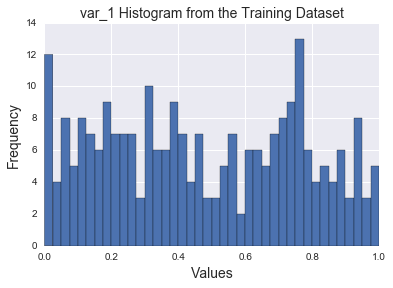

In [12]:
#A histogram of var_1 is shown below, all other varaibles follow the same flat pattern as shown in the boxplots
X.var_1.hist(bins=40)
plt.title('var_1 Histogram from the Training Dataset', fontsize=14)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

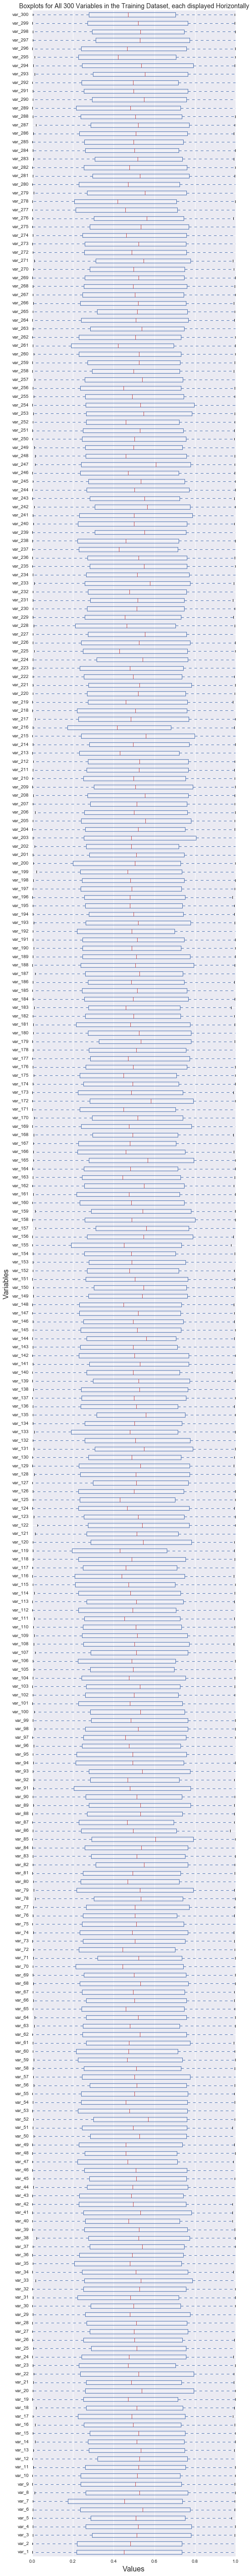

In [13]:
#boxplots confirm all variables are identically distributed
X.plot.box(vert=False,figsize=(8,100))
plt.title('Boxplots for All 300 Variables in the Training Dataset, each displayed Horizontally', fontsize=14)
plt.xlabel('Values', fontsize=16)
plt.ylabel('Variables', fontsize=16)
plt.show()

A 95% confidence interval results in a narrow range for the mean across all 300 variables: 0.50 +/- 0.03 or [0.47,0.53]

In [14]:
#the mean of each variable is computed and appended to an list of the variable means. 
#We compute the avg of this list and standard deviation
avg = []
for col in df_train.iloc[:,3:].columns:
    avg.append(df_train.iloc[:,3:][col].mean())

print("95 percent Confidence Interval for variable means: %0.2f (+/- %0.2f)" % (np.mean(avg), np.std(avg) * 1.96))

95 percent Confidence Interval for variable means: 0.50 (+/- 0.03)


Since all variables share approximately the same mean and distribution, we will check if collinearity exists between the variables. If collinearity is present, this may offer an opportunity to apply dimensionality reduction techniques like Principal Components Analysis to reduce the number of features and account for the collinearity. 

### Collinearity Analysis

The correlation matrix is computed for the training dataset variables. However, this is a 300 x 300 matrix and is inconvenient to inspect quickly. 

Instead, the heatmap below is a visual representation of the correlation matrix, with each value in the correlation matrix being represented by a colored gradient. A brightly colored Red or Blue would indicate strong colliearity.  

As we can see below, there is no evidence of collinearity between any of the variables

Correlation Matrix dimensions: (300, 300)


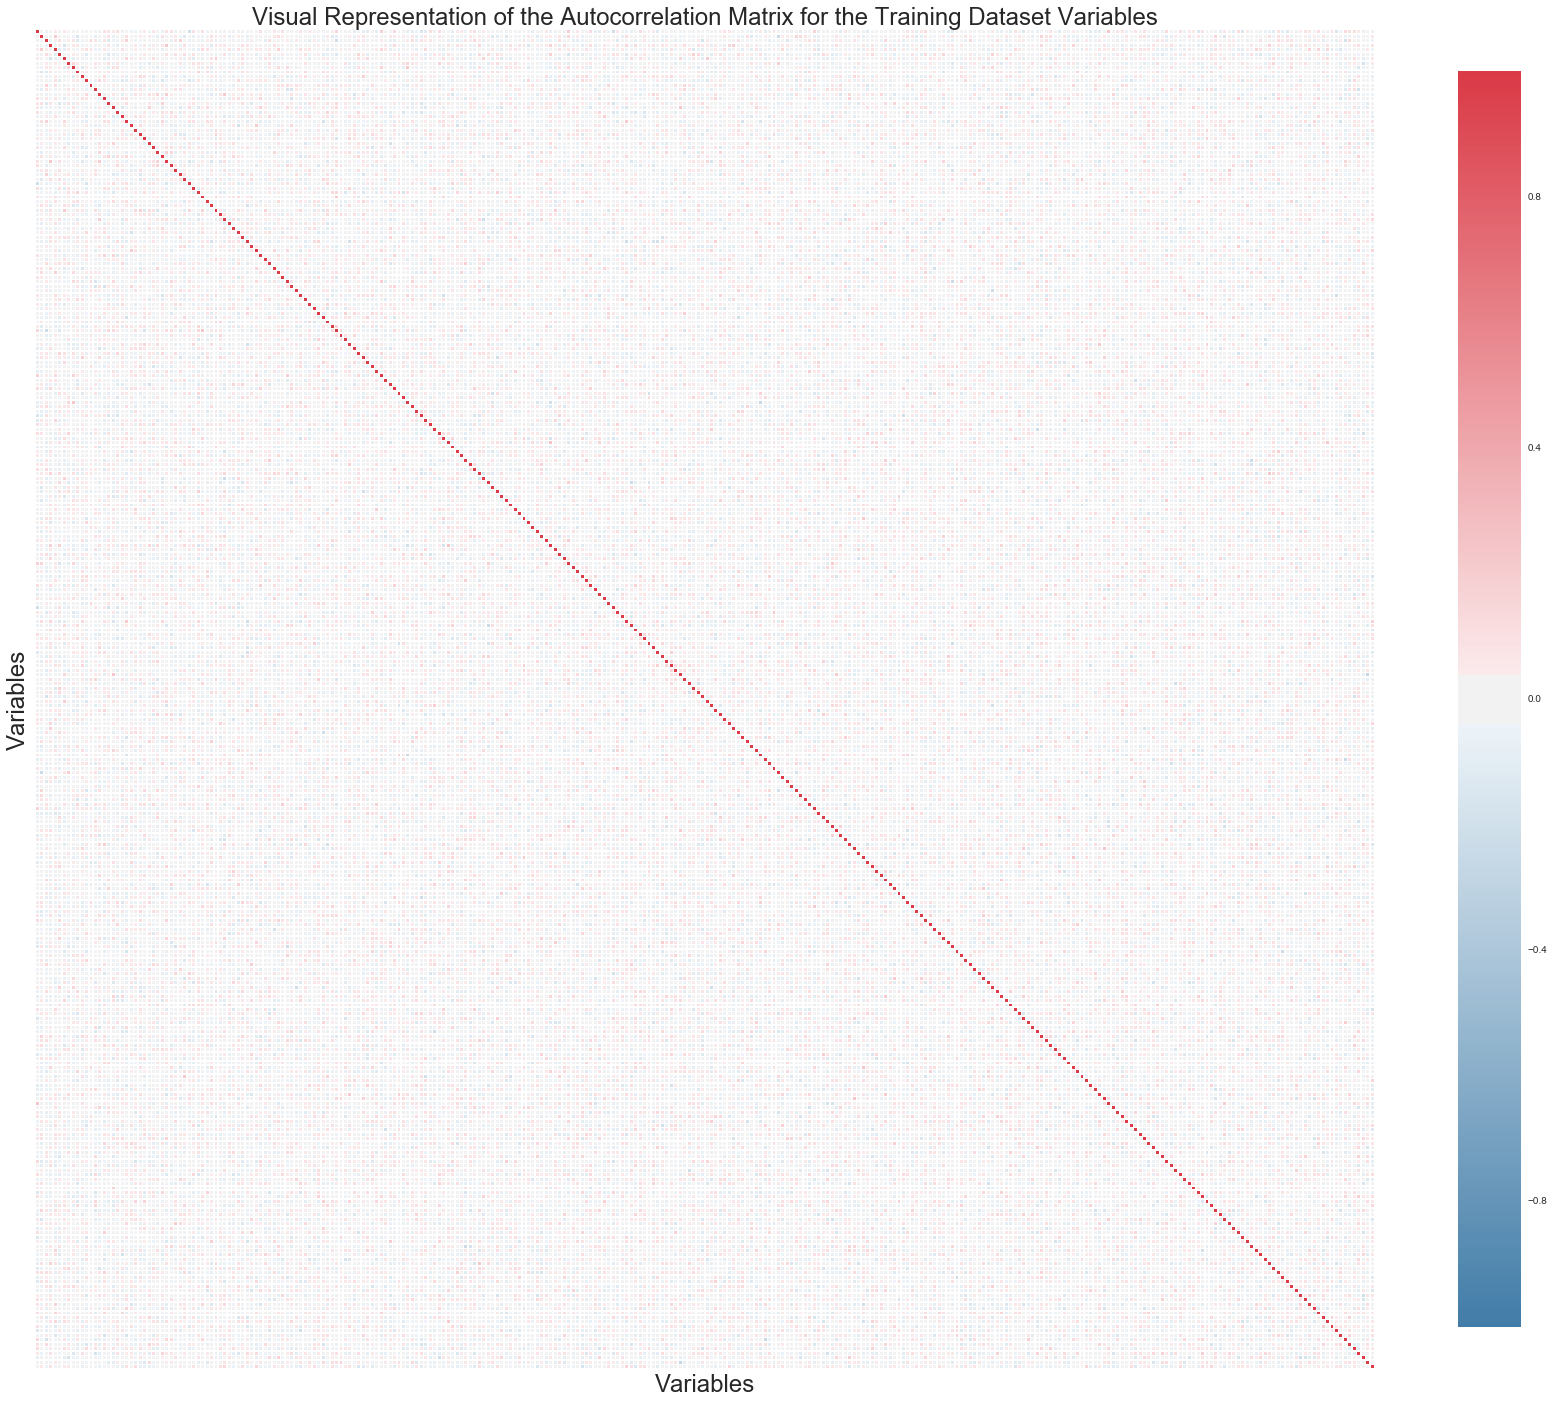

In [15]:
# Compute the correlation matrix
corr = X.corr()
print ("Correlation Matrix dimensions:", corr.shape)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False

#set background style
sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=False, yticklabels=False,
            linewidths=.5, cbar_kws={"shrink": .75}, ax=ax, annot = False, fmt = '.2f')

plt.title('Visual Representation of the Autocorrelation Matrix for the Training Dataset Variables', fontsize = 24)
plt.xlabel('Variables', fontsize = 24)
plt.ylabel('Variables', fontsize = 24)
plt.show()

The histogram below illustrates the range of correlation values for var_1 from the autocorrelation matrix. It is clear that most correlations fall between -0.2 and 0.2, are centered about 0.0, and the single 1.0 represents var_1's correlation with itself.

Again, there is no evidence of collinearity amongst the variables.

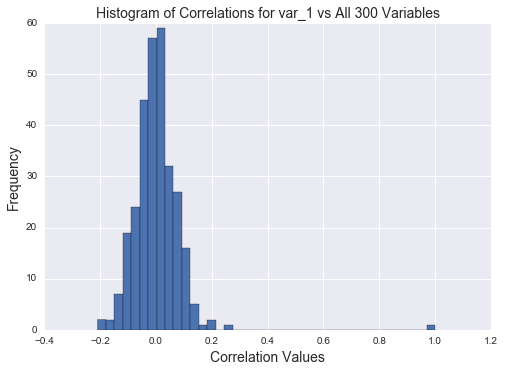

In [16]:
# +/- 0.2 Pearson's correlation w.r.t. all other variables. 
corr.var_1.hist(bins = 40)
plt.title('Histogram of Correlations for var_1 vs All 300 Variables', fontsize = 14)
plt.xlabel('Correlation Values', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.show()

### Exploring the Relationship Between our Binary Target and All Variable Means

First, we split our training dataset, df_train, by the target binary variable. For each new dataframe, class_0 and class_1, we can compute a confidence interval from the mean value of each training variable. The idea here is to get a better understanding of how each class is associated with its training variables. This analysis may offer insights into how the dataset could be modeled.   

As we can see below, the 95% confidence intervals show a large amount of overlap between the classes. There is almost no differentiality between the classes with respect to the mean of the variables.

95% Confidence Intervals:
- Class_0: [ 0.45, 0.57 ]
- Class_1: [ 0.44, 0.54 ]

The means differ by only 0.02, the computations are detailed below:

In [17]:
#Each dataframe below contains the variables associated with either 0 or 1 classes
class_0 = df_train[df_train['target_eval'] == 0].iloc[:,3:]
class_1 = df_train[df_train['target_eval'] == 1].iloc[:,3:]

In [18]:
#the mean of each variable is computed and appended to an list of the variable means. 
#We compute the avg of this list and standard deviation
avg = []
for col in class_0.columns:
    avg.append(class_0[col].mean())

print ('Class 0:')
print("95 percent Confidence Interval for variable means: %0.2f (+/- %0.2f)" % (np.mean(avg), np.std(avg) * 1.96))

Class 0:
95 percent Confidence Interval for variable means: 0.51 (+/- 0.06)


In [19]:
#the mean of each variable is computed and appended to an list of the variable means. 
#We compute the avg of this list and standard deviation
avg = []
for col in class_1.columns:
    avg.append(class_1[col].mean())

print ('Class 1:')
print("95 percent Confidence Interval for variable means: %0.2f (+/- %0.2f)" % (np.mean(avg), np.std(avg) * 1.96))

Class 1:
95 percent Confidence Interval for variable means: 0.49 (+/- 0.05)


## Exploring the Test Set

Similarly, the boxplots below show that all variables in the Test dataset are identially distributed around mean of 0.5 as in the training dataset

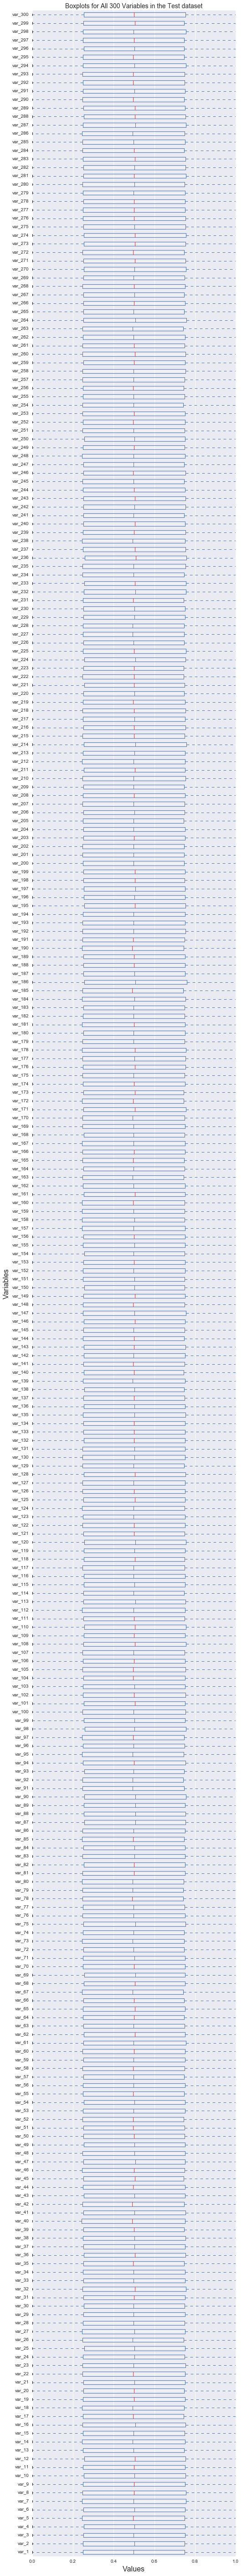

In [20]:
#Test dataset boxplots
df_test.iloc[:,3:].plot.box(vert=False,figsize=(8,100))
plt.title('Boxplots for All 300 Variables in the Test dataset', fontsize=14)
plt.xlabel('Values', fontsize=16)
plt.ylabel('Variables', fontsize=16)
plt.show()

Again, we see that the variables in the test set show a random distribution with little to no correlations between variables as in the training dataset:

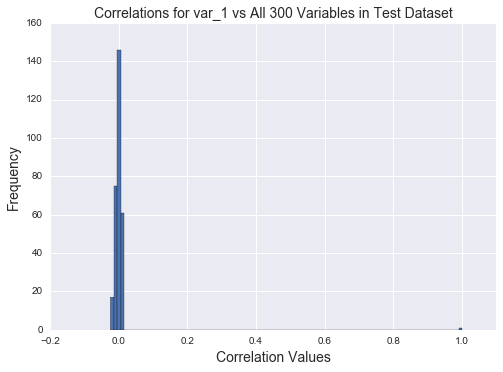

In [21]:
# +/- 0.05 Pearson's correlation w.r.t. all other variables.
df_test.iloc[:,3:].corr().var_1.hist(bins = 100) #correlation matrix is computed
plt.title('Correlations for var_1 vs All 300 Variables in Test Dataset', fontsize = 14)
plt.xlabel('Correlation Values', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.xlim([-.2,1.1])
plt.show()

It is evident from the observations detailed above that the training and test variables are random, show no collinearity, and therefore offer little information to differentiate between the binary target if the models are solely based on the mean. 

Perhaps there is a reliable signal buried amongst all the noise, but when modeled as a whole, the algorithms evaluated below will encounter difficulties in accurately predicting true classes due to the apparent randomness of all variables. Moreover, we are only using 250 samples to train a model that is expected to predict values from a much larger dataset. This is a critical problem as the 250 samples may not be an adequate representation of the entire dataset. Also, many of these algorithms are designed to perform best when distributions are normal. It is clear here, that all of the variables are non-normal. 

# Building Models:

As denoted earlier:

In [22]:
#From the training dataset, let's define our target and training variables
y = df_train['target_eval']
X = df_train.iloc[:,3:]

#From the test dataset, we define the test data below
X_test = df_test.iloc[:,3:]

### Model Evaluation via a 10-fold Cross Validation

First, we create a Cross-validation object (cv), a random permutation cross-validation iterator (ShuffleSplit) to evaluate our models consistently and prevent overfitting. We define our cv iterator to generate 10 folds/iterations, with a 70/30% train/test split ratio per fold. 

In [23]:
#The seed value allows for consistent comparisons between models
#We will use this cv object throughout our model evaluations

cv = ShuffleSplit(n = len(y), n_iter=10, test_size=0.3, random_state=42)

### Model 1: Gaussian Naive Bayes Model

A Gaussian Naive Bayes model achieves a 66% accuracy via a 10-fold cross validation on the training dataset. 

The Gaussian Naive Bayes algorithm assumes that all examples are independent and follow a normal distribution. Thus, the algorithm estimates the best fitting Gaussian model to represent the data and thus provide estimated probabilities for new examples based on the fitted gaussian.

In [24]:
#sklearn's cross_val_score function will compute accuracies given an estimator, a dataset, and a custom cv object
scores = cross_val_score(GaussianNB(), X, y, cv=cv)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.660 (+/- 0.108)


The predicted probabilities from this model are computed below:

In [25]:
#Define our classifier object/model
gnb = GaussianNB()

#Fit the model with our training set
gnb.fit(X, y)

#determine predicted values based on our single test set
y_pred = gnb.predict(X_test)
preds = pd.DataFrame(data=y_pred, index=None, columns = ['Predictions'])

#Determine probabilities of each class
probs = gnb.predict_proba(X_test)
probs = pd.DataFrame(data=probs, index=None, columns = ['Class_0','Class_1'])

#Concatenate probabilities and predictions dataframes
gnbModel = pd.concat([probs, preds], axis=1)

#A snapshot of the first 10 predictions from the test dataset
gnbModel.head(10)

,Class_0,Class_1,Predictions
0,0.057771,0.942229,1
1,0.218688,0.781312,1
2,0.101443,0.898557,1
3,0.115506,0.884494,1
4,0.123023,0.876977,1
5,0.765605,0.234395,0
6,0.267248,0.732752,1
7,0.360982,0.639018,1
8,0.037805,0.962195,1
9,0.999147,0.000853,0


Grouping by 'Predictions' we can see that both classes appear in similar quantities, as expected.

In [26]:
gnbModel.groupby('Predictions').count()

,Class_0,Class_1
Predictions,,
0,9314,9314
1,10436,10436


### Model 2: Stochastic Gradient Descent Classifier (SGDClassifier)

Applying sklearn's SGDClassifier allows us to evaluate models by testing several different loss functions in a Grid Search process using a stochastic optimizer. Again, our cross-validation object creates 10-fold, 70/30 train/test splits amongst the training dataset to evaluate each model. 

The model with the highest accuracy from the cv iterations on the training dataset is selected to predict probabilities. 

4 different loss functions are evaluated (hinge (SVM), log (logistic), modified_huber (SVM-like) and squared_hinge (squared hinge penalty)), although only 2 can provide probability estimates (log and modified_huber). We try all 4 to observe their accuracies. Each loss function may be paired with a particular type of regularization and regularization weighing, alpha. 

In [27]:
#Define the set of parameters to be evaluated in the GridSearch
# alpha: regularization term
# loss: loss function. Logistic and Modified_huber losses allow for probability estimates.
# penalty: regularization method, l1:lasso, l2:ridge, elasticnet:l1+l2
parameters = {'loss':['hinge','log','modified_huber','squared_hinge'], 
              'penalty' : ['l2','l1','elasticnet'],
              'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]}

#The regularization methods expect gaussian distributions that are centered and normalized
#Thus the standardScaler is applied here to normalize our training dataset
X = StandardScaler().fit_transform(X)

In [28]:
#Define our Classifier object
sgd = SGDClassifier(n_jobs=-1) #use all available CPUs

#Apply GridSearch on specified classifier, parameter, and cross validation method
gs = GridSearchCV(sgd, parameters, cv=cv, verbose=1)
gs.fit(X, y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    3.1s finished


GridSearchCV(cv=ShuffleSplit(250, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'], 'alpha': [0.0001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [29]:
#Sort the GridSearch results by highest mean accuracy score
sorted(gs.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.71733, std: 0.03666, params: {'penalty': 'l1', 'loss': 'log', 'alpha': 0.0001},
 mean: 0.71200, std: 0.02325, params: {'penalty': 'l2', 'loss': 'hinge', 'alpha': 0.1},
 mean: 0.70400, std: 0.05053, params: {'penalty': 'elasticnet', 'loss': 'log', 'alpha': 0.0001},
 mean: 0.70133, std: 0.04225, params: {'penalty': 'l2', 'loss': 'modified_huber', 'alpha': 0.0001},
 mean: 0.69600, std: 0.02444, params: {'penalty': 'elasticnet', 'loss': 'hinge', 'alpha': 0.1},
 mean: 0.69467, std: 0.03697, params: {'penalty': 'elasticnet', 'loss': 'modified_huber', 'alpha': 0.0001},
 mean: 0.69067, std: 0.02294, params: {'penalty': 'l2', 'loss': 'hinge', 'alpha': 0.01},
 mean: 0.69067, std: 0.02294, params: {'penalty': 'l2', 'loss': 'modified_huber', 'alpha': 0.01},
 mean: 0.68933, std: 0.04002, params: {'penalty': 'l1', 'loss': 'log', 'alpha': 0.01},
 mean: 0.68800, std: 0.03964, params: {'penalty': 'l2', 'loss': 'log', 'alpha': 0.0001},
 mean: 0.68800, std: 0.06316, params: {'penalty': 'l2', 'lo

In [30]:
#Display the highest score and parameter values that achieved the highest accuracy
print (gs.best_score_, gs.best_params_)

0.717333333333 {'penalty': 'l1', 'loss': 'log', 'alpha': 0.0001}


### Apply optimal grid search parameter values to a model to predict probabilities

In [31]:
#Here, we apply the best parameters from the Grid Search to build a single SGDClassifier model
gs_sgd = SGDClassifier(loss=gs.best_params_['loss'], 
                       penalty=gs.best_params_['penalty'],
                       alpha=gs.best_params_['alpha'])

#Fit the model with our training set
gs_sgd.fit(X, y)

#determine predicted values based on our single test set
y_pred = gs_sgd.predict(X_test)
preds = pd.DataFrame(data=y_pred, index=None, columns = ['Predictions'])

#Determine probabilities of each class
probs = gs_sgd.predict_proba(X_test)
probs = pd.DataFrame(data=probs, index=None, columns = ['Class_0','Class_1'])

#Concatenate probabilities and predictions dataframes from SGD model
SGDLogModel = pd.concat([probs, preds], axis=1)
SGDLogModel.head(10)

,Class_0,Class_1,Predictions
0,1.0,0.0,0
1,1.0,0.0,0
2,1.0,0.0,0
3,1.0,0.0,0
4,1.0,0.0,0
5,1.0,0.0,0
6,1.0,0.0,0
7,1.0,0.0,0
8,1.0,0.0,0
9,1.0,0.0,0


Grouping by 'Predictions' we can see that only 1 class is predicted from the test examples. Demonstrating the effects of a small training dataset and uninformative training variables.

In [32]:
SGDLogModel.groupby('Predictions').count()

,Class_0,Class_1
Predictions,,
0,19750,19750


Since the accuracies in the GridSearch do not show large accuracy gaps between models, we will create another model with the 'Modified Huber' loss function (4th ranked model in Grid Search) to generate another set of probabilities and observe how its predictions are distributed. 

The modified huber model from the grid search achieved an accuracy of 0.697 (+/- 0.034) versus the best model above which achieved an accuracy of 0.709 (+/- 0.057)

In [33]:
#Here, we apply the best parameters from the Grid Search to build a single SGDClassifier model
gs_sgd_mh = SGDClassifier(loss='modified_huber', 
                       penalty='l1',
                       alpha=0.0001)

#Fit the model with our training set
gs_sgd_mh.fit(X, y)

#determine predicted values based on our single test set
y_pred = gs_sgd_mh.predict(X_test)
preds = pd.DataFrame(data=y_pred, index=None, columns = ['Predictions'])

#Determine probabilities of each class
probs = gs_sgd_mh.predict_proba(X_test)
probs = pd.DataFrame(data=probs, index=None, columns = ['Class_0','Class_1'])

#Concatenate probabilities and predictions dataframes from SGD model
SGD_MH_Model = pd.concat([probs, preds], axis=1)
SGD_MH_Model.head(10)

,Class_0,Class_1,Predictions
0,1.0,0.0,0
1,1.0,0.0,0
2,1.0,0.0,0
3,1.0,0.0,0
4,1.0,0.0,0
5,1.0,0.0,0
6,1.0,0.0,0
7,1.0,0.0,0
8,1.0,0.0,0
9,1.0,0.0,0


Again, grouping by 'Predictions' we can see that only 1 class is predicted from the test examples. Demonstrating the effects of a small training dataset and uninformative training variables.

In [34]:
SGD_MH_Model.groupby('Predictions').count()

,Class_0,Class_1
Predictions,,
0,19750,19750


### Model 3: Random Forests Classifier

The Random Forests algorithm offers a non-linear approach to classification problems. Random Forests is less susceptible to overfitting than a single decision tree due to its sampling with replacement of the training dataset to build its trees. 

We will evaluate several models using a GridSearch process. 

In [35]:
#Resetting our training dataset
y = df_train['target_eval']
X = df_train.iloc[:,3:]

#RanfomForests Classifier parameters
# n_estimators: forest size/number of decision trees
# criterion: homogeneity measure, decision criteria
# max_features: method by which number of features are selected per tree
parameters = {'n_estimators': [5,10,15,20,25],
              'criterion':['gini','entropy'],
              'max_features':['sqrt','log2']}

In [36]:
rf = RandomForestClassifier(n_jobs=-1)
gsrf = GridSearchCV(rf, parameters, cv=cv, verbose=1)

gsrf.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   11.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   44.5s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   44.7s finished


GridSearchCV(cv=ShuffleSplit(250, n_iter=10, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [37]:
#Sort the GridSearch results by highest mean accuracy score
sorted(gsrf.grid_scores_,key=lambda x: x[1], reverse=True)

[mean: 0.55733, std: 0.05226, params: {'n_estimators': 25, 'max_features': 'sqrt', 'criterion': 'entropy'},
 mean: 0.55600, std: 0.05302, params: {'n_estimators': 10, 'max_features': 'sqrt', 'criterion': 'gini'},
 mean: 0.55600, std: 0.06141, params: {'n_estimators': 20, 'max_features': 'sqrt', 'criterion': 'gini'},
 mean: 0.55467, std: 0.03538, params: {'n_estimators': 20, 'max_features': 'sqrt', 'criterion': 'entropy'},
 mean: 0.55200, std: 0.05472, params: {'n_estimators': 10, 'max_features': 'log2', 'criterion': 'entropy'},
 mean: 0.54933, std: 0.05259, params: {'n_estimators': 15, 'max_features': 'sqrt', 'criterion': 'entropy'},
 mean: 0.54800, std: 0.04933, params: {'n_estimators': 5, 'max_features': 'log2', 'criterion': 'entropy'},
 mean: 0.54667, std: 0.05963, params: {'n_estimators': 15, 'max_features': 'sqrt', 'criterion': 'gini'},
 mean: 0.54400, std: 0.04079, params: {'n_estimators': 10, 'max_features': 'log2', 'criterion': 'gini'},
 mean: 0.54000, std: 0.08353, params: {'n

In [38]:
#display the best scoring accuracy and parameters
print (gsrf.best_score_, gsrf.best_params_)

0.557333333333 {'n_estimators': 25, 'max_features': 'sqrt', 'criterion': 'entropy'}


### Apply the Optimal GridSearch values to a random forests model to predict probabilities

In [39]:
gsrf_model = RandomForestClassifier(n_estimators = gsrf.best_params_['n_estimators'],
                                    criterion = gsrf.best_params_['criterion'],
                                    max_features = gsrf.best_params_['max_features'],
                                    n_jobs=-1)

#Fit the model with our training set
gsrf_model.fit(X, y)

#determine predicted values based on our single test set
y_pred = gsrf_model.predict(X_test)
preds = pd.DataFrame(data=y_pred, index=None, columns = ['Predictions'])

#Determine probabilities of each class
probs = gsrf_model.predict_proba(X_test)
probs = pd.DataFrame(data=probs, index=None, columns = ['Class_0','Class_1'])

#Concatenate probabilities and predictions dataframes from rf model
rfModel = pd.concat([probs, preds], axis=1)
rfModel.head(10)

,Class_0,Class_1,Predictions
0,0.40,0.60,1
1,0.68,0.32,0
2,0.56,0.44,0
3,0.60,0.40,0
4,0.36,0.64,1
5,0.40,0.60,1
6,0.40,0.60,1
7,0.72,0.28,0
8,0.52,0.48,0
9,0.72,0.28,0


The random forests model is able to provide predictions for both classes although the best achieved accuracy is only 0.55 versus 0.66 of the Gaussian Naive Bayes model. 

In [40]:
rfModel.groupby('Predictions').count()

,Class_0,Class_1
Predictions,,
0,10799,10799
1,8951,8951


# Summary:

Overall, it appears that the entire dataset was generated at random and thus making it difficult for algorithms to accurately discern between the binary target.  

From the attempted models, the Gaussian Naive Bayes model offers the best accuracies within the training set and provides predictions for both classes 0 and 1. The predicted probabilities from the Gaussian model will be submitted. 

In [41]:
gnbModel.to_csv('Predicted_Probabilities.csv', encoding='utf-8')